In [ ]:
!pip install understat

!pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()


import asyncio
import json
import aiohttp
from understat import Understat
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
async def main():
    async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        players = await understat.get_league_players(
            "epl",
            2020,
            position="GK"
        )
        # print(json.dumps(players))
        return players
loop = asyncio.new_event_loop()
players_all = loop.run_until_complete(main())

async def get_player_matches(id):
    async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        players = await understat.get_player_matches(player_id=id,season = '2019')
        # print(json.dumps(players))
        return players
loop = asyncio.new_event_loop()
                            
async def get_match_players(id):
    async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        players = await understat.get_match_players(match_id = id)
        # print(json.dumps(players))
        return players
loop = asyncio.new_event_loop()


https://understat.readthedocs.io/en/latest/classes/understat.html#the-functions


In [ ]:
df_all = pd.DataFrame.from_dict(players_all)
df_all = df_all[['id','player_name','time','games']]
df = df_all.astype({'time': 'int32','games':'int32'})
top_ten_gk = df.sort_values(by='time',ascending=False)[:20].set_index('player_name')

In [ ]:
xG,goals = [],[]
for player,id in zip(top_ten_gk.index,top_ten_gk['id']):
    print(player)
    #get match ID's of all the games the player has played in:
    match_ids= loop.run_until_complete(get_player_matches(id))
    sum_xG = []
    sum_goals = []
    ids = []
    for match in match_ids:
      match_data= loop.run_until_complete(get_match_players(match['id']))
      if pd.DataFrame.from_dict(match_data['a']).T['player'].str.contains(player).any():
        sum_xG.append(pd.DataFrame.from_dict(match_data['h']).T.astype({'xG': 'float'}).sum()['xG'])
        sum_goals.append(pd.DataFrame.from_dict(match_data['h']).T.astype({'goals': 'float'}).sum()['goals'])
      else:
        sum_xG.append(pd.DataFrame.from_dict(match_data['a']).T.astype({'xG': 'float'}).sum()['xG'])
        sum_goals.append(pd.DataFrame.from_dict(match_data['a']).T.astype({'goals': 'float'}).sum()['goals'])
    xG.append(np.sum(sum_xG))
    goals.append(np.sum(sum_goals))
    # print('Total xG: {}, Total goals: {}'.format(np.sum(sum_xG),np.sum(sum_goals)))

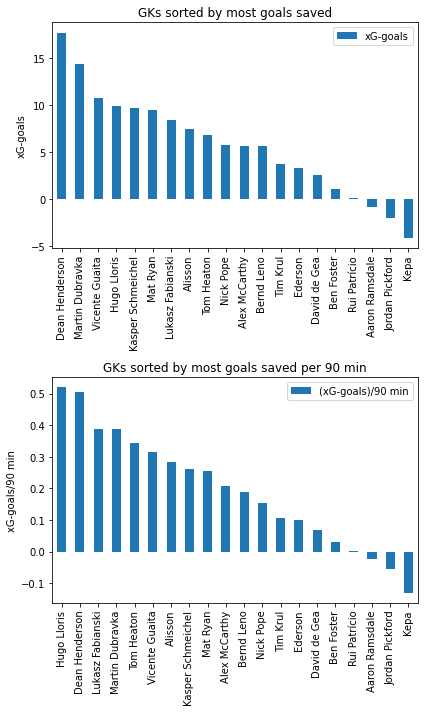

In [ ]:

top_ten_gk['Total xG'] = xG
top_ten_gk['Total goals'] = goals
top_ten_gk['xG-goals'] = top_ten_gk['Total xG']-top_ten_gk['Total goals']
top_ten_gk['(xG-goals)/90 min'] = top_ten_gk['xG-goals']/top_ten_gk['time']*90

fig,ax = plt.subplots(2,1,figsize = (6,10))
top_ten_gk.sort_values(by='xG-goals',ascending = False).plot.bar(y='xG-goals',ax = ax[0])
ax[0].set_ylabel('xG-goals')
ax[0].set_xlabel("")
ax[0].set_title('GKs sorted by most goals saved')

ax[1] = top_ten_gk.sort_values(by='(xG-goals)/90 min',ascending = False).plot.bar(y='(xG-goals)/90 min',ax = ax[1])
ax[1].set_ylabel('xG-goals/90 min')
ax[1].set_xlabel("")
ax[1].set_title('GKs sorted by most goals saved per 90 min')

plt.tight_layout()
plt.show()